In [1]:
import time
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import gmsh

plt.rcdefaults()
plt.style.use('seaborn-v0_8-paper')
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from ttcrpy.tmesh import Mesh2d

# Example 2 - 2D model with topography

In this example, we use gmsh to create a 2D model that contains two irregular layers.  We then model first and reflected arrival times for receivers located at the surface.

The approach to get reflected arrival times is to 
1. record the direct arrival times at points along the interface between the layers
2. use these as a second source for a subsequent modeling run.

Let's start be creating the mesh.

In [2]:
gmsh.initialize()

gmsh.clear()
mesh_size = 0.5

mesh_size2 = 0.2*mesh_size

# points for the surface
p1 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0, meshSize=mesh_size)
p2 = gmsh.model.geo.addPoint(1.0, 0.0, 0.0, meshSize=mesh_size)
p3 = gmsh.model.geo.addPoint(5.0, 0.0, -2.0, meshSize=mesh_size)
p4 = gmsh.model.geo.addPoint(10.0, 0.0, 2.0, meshSize=mesh_size)
p5 = gmsh.model.geo.addPoint(14.0, 0.0, 0.0, meshSize=mesh_size)
p6 = gmsh.model.geo.addPoint(15.0, 0.0, 0.0, meshSize=mesh_size)

# points for the interface between the layers, we use a smaller
# mesh_size to get a denser distribution along the interface
p7 = gmsh.model.geo.addPoint(15.0, 0.0, 3.0, meshSize=mesh_size2)
p8 = gmsh.model.geo.addPoint(10.0, 0.0, 2.0, meshSize=mesh_size2)
p9 = gmsh.model.geo.addPoint(5.0, 0.0, 4.0, meshSize=mesh_size2)
p10 = gmsh.model.geo.addPoint(0.0, 0.0, 3.0, meshSize=mesh_size2)

# bottom
p11 = gmsh.model.geo.addPoint(15.0, 0.0, 6.0, meshSize=mesh_size)
p12 = gmsh.model.geo.addPoint(0.0, 0.0, 6.0, meshSize=mesh_size)

# Get curved surface using BSplines
surf_tag = gmsh.model.geo.addBSpline([p1, p2, p3, p4, p5, p6], tag=10)
gmsh.model.geo.addLine(p6, p7, tag=11)
refl_tag = gmsh.model.geo.addBSpline([p7, p8, p9, p10], tag=12)
gmsh.model.geo.addLine(p10, p1, tag=13)

gmsh.model.geo.addLine(p7, p11, tag=14)
gmsh.model.geo.addLine(p11, p12, tag=15)
gmsh.model.geo.addLine(p12, p10, tag=16)

gmsh.model.geo.addCurveLoop([10, 11, 12, 13], tag=21)
gmsh.model.geo.addCurveLoop([-12, 14, 15, 16], tag=22)

gmsh.model.geo.addPlaneSurface([21], tag=31)
gmsh.model.geo.addPlaneSurface([22], tag=32)

gmsh.model.geo.synchronize()

# create physical entities to be able to retrieve node 
# coordinates at the surface & interface, and to assign
# velocity
pl1 = gmsh.model.addPhysicalGroup(1, [surf_tag])
pl2 = gmsh.model.addPhysicalGroup(1, [refl_tag])

ps1 = gmsh.model.addPhysicalGroup(2, [31])
ps2 = gmsh.model.addPhysicalGroup(2, [32])

gmsh.model.setPhysicalName(1, pl1, "surface")
gmsh.model.setPhysicalName(1, pl2, "reflector")
gmsh.model.setPhysicalName(2, ps1, "layer_1")
gmsh.model.setPhysicalName(2, ps2, "layer_2")

# We can then generate a 2D mesh...
gmsh.model.mesh.generate(2)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 10 (Nurb)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Nurb)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (Line)
Info    : Done meshing 1D (Wall 0.00697358s, CPU 0.006745s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 31 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 32 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.029886s, CPU 0.028847s)
Info    : 2391 nodes 4931 elements


We must now loop over triangles and assign the velocity corresponding to the appropriate layer.  Along the way, we store node indices for all triangles in a single list.  

We also collect the coordinates of the nodes at the surface and along the interface.

In [3]:
slowness = []
triangles = []

surface = []     # node coordinates at the surface
reflector = []   # node coordinates at the interface

for dim, tag in gmsh.model.getEntities():
    
    if dim == 1:
        # get the nodes on the BSplines
        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim, tag)
        physicalTags = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
        if len(physicalTags) == 0:
            continue
        name = gmsh.model.getPhysicalName(dim, physicalTags[0])
        
        if name == 'surface':
            for tag in np.unique(elemNodeTags[0]):
                node = gmsh.model.mesh.getNode(tag)
                surface.append(node[0])
        elif name == 'reflector':
            # get coordinates of the nodes on the interface
            for tag in np.unique(elemNodeTags[0]):
                node = gmsh.model.mesh.getNode(tag)
                reflector.append(node[0])
        
    elif dim == 2:
        # assign velocity
        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim, tag)
        physicalTags = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
        name = gmsh.model.getPhysicalName(dim, physicalTags[0])
        
        for n in range(len(elemTags[0])):
            t = elemNodeTags[0][3*n:(3*n+3)]
            triangles.append(t)
            
            if name == "layer_1":
                slowness.append(1.0)    # velocity of 1
            else:
                slowness.append(0.333)  # velocity of 3

It should be noted that the mesh contains nodes not used to form the triangles (i.e. nodes used with the B-splines).  For that reason, we store only the nodes that are actually used for raytracing in a new list.

Also, nodes are tagged by number starting at 1, but in `ttcrpy` we want to access the nodes in an array for which indices start at 0, so we have to build an equivalence table.

In [4]:
help(gmsh.model.mesh.getNode)

Help on function getNode in module gmsh:

getNode(nodeTag)
    gmsh.model.mesh.getNode(nodeTag)
    
    Get the coordinates and the parametric coordinates (if any) of the node
    with tag `tag', as well as the dimension `dim' and tag `tag' of the entity
    on which the node is classified. This function relies on an internal cache
    (a vector in case of dense node numbering, a map otherwise); for large
    meshes accessing nodes in bulk is often preferable.
    
    Return `coord', `parametricCoord', `dim', `tag'.
    
    Types:
    - `nodeTag': size
    - `coord': vector of doubles
    - `parametricCoord': vector of doubles
    - `dim': integer
    - `tag': integer



In [5]:
slowness = np.array(slowness)   # convert to numpy array
triangles = np.array(triangles)
surface = np.array(surface)
reflector = np.array(reflector)

uniqueTags = np.unique(triangles)  # we want to store the nodes only once

equiv = np.empty((int(1+uniqueTags.max()),))
nodes = []
for n, tag in enumerate(uniqueTags):
    equiv[tag] = n
    node = gmsh.model.mesh.getNode(tag)
    nodes.append(node[0])

for n1 in range(triangles.shape[0]):
    for n2 in range(triangles.shape[1]):
        triangles[n1, n2] = equiv[triangles[n1, n2]]  # change the tag for the corresponding index
        
nodes = np.array(nodes)   # convert to numpy array
nodes = np.c_[nodes[:, 0], nodes[:, 2]]  # keep only x & z

# sort coordinates (for later plotting)
ind = np.argsort(surface[:, 0])
surface = surface[ind, :]
ind = np.argsort(reflector[:, 0])
reflector = reflector[ind, :]

gmsh.finalize()  # we're done with gmsh

Let's now look at the model.

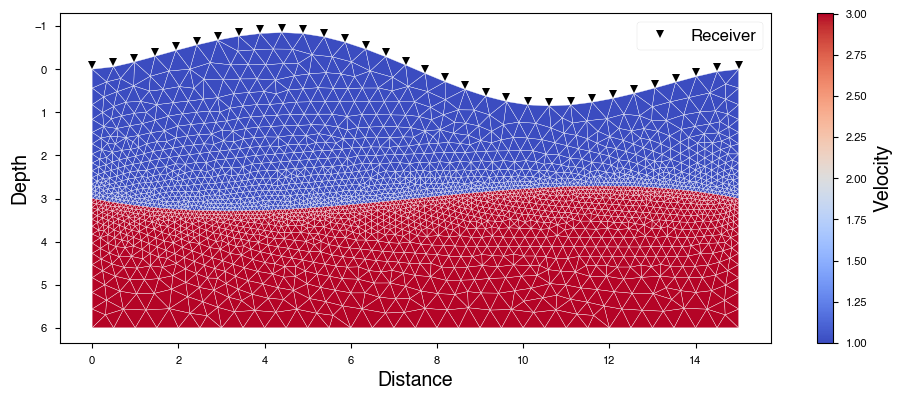

In [6]:
V = 1./slowness  # velocity is more intuitive than slowness

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, V, cmap='coolwarm', edgecolors='w')
ax.plot(surface[:, 0], surface[:, 2]-0.1, 'kv', label='Receiver')
ax.legend(fontsize=12)
cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Velocity', fontsize=14)

ax.invert_yaxis()
ax.set_aspect('equal', 'box')

plt.xlabel('Distance', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.tight_layout()

plt.savefig('figs/example2_model.pdf', bbox_inches='tight')
plt.show()

We are now ready to build the `ttcrpy` mesh and perform raytracing.  We need to record arrival times at the surface as well as at the nodes on the interface.

In [7]:
# create the mesh (values in trangles are unsigned long, we must pass int)

mesh = Mesh2d(nodes, triangles.astype(np.int64), method='SPM', n_secondary=25)

mesh.to_vtk({'slowness': slowness}, 'example2')

# create a source
Tx = np.array([[0.15, 0.15]])

# include surface and interface nodes.  (We drop the y coordinate)
Rx = np.r_[surface[:, ::2], reflector[:, ::2]]

# we can now compute traveltimes and raypaths
tt, rays = mesh.raytrace(Tx, Rx, slowness, return_rays=True)

/var/folders/kd/v1qqm8qd15506q5jp_2tz_bw0000gn/T/ipykernel_47179/1692862106.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tt, rays = mesh.raytrace(Tx, Rx, slowness, return_rays=True)


Let's now have a look at the results.  Here, we want to see the spatial distribution of traveltimes as well as the raypaths.

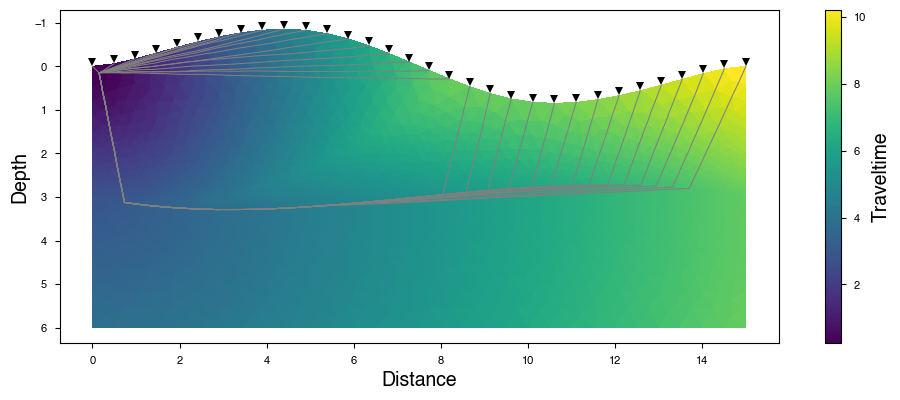

In [8]:
# let's first retrieve traveltimes at the nodes of the mesh
mesh_tt = mesh.get_grid_traveltimes()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, mesh_tt) #, cmap='coolwarm')
ax.plot(surface[:, 0], surface[:, 2]-0.1, 'kv')

# add rays for the receivers at the surface
nRx = surface.shape[0]
for r in rays[:nRx]:
    plt.plot(r[:,0], r[:,1], c=[0.5, 0.5, 0.5], lw=0.75)
    
ax.invert_yaxis()
ax.set_aspect('equal', 'box')

cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Traveltime', fontsize=14)

plt.xlabel('Distance', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.tight_layout()

plt.savefig('figs/example2_rays.pdf', bbox_inches='tight')

plt.show()

We can now compute reflected traveltimes using the first arrival times recorded at the interface as a new source.

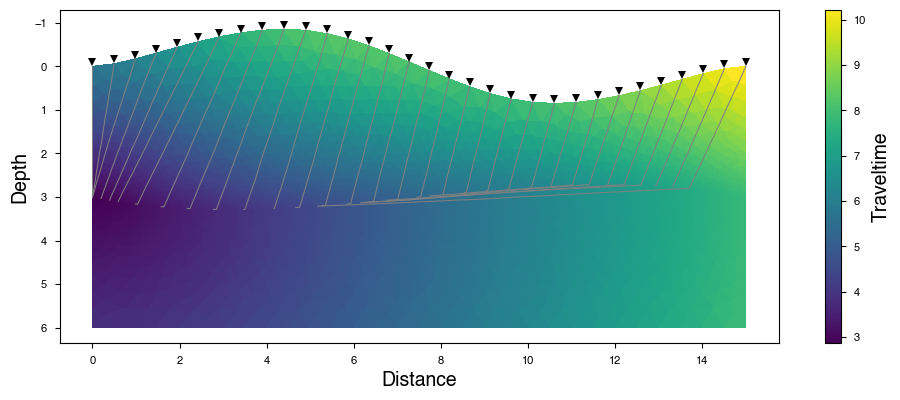

In [9]:
# first column is arrival time, 2nd & 3rd columns at x & z
Tx = np.c_[tt[nRx:].reshape(-1, 1), reflector[:, ::2]]
Rx = surface[:, ::2]

# use aggregate_src to treat all Tx nodes as a single source
tt2, rays2 = mesh.raytrace(Tx, Rx, slowness, return_rays=True, aggregate_src=True)

mesh_tt = mesh.get_grid_traveltimes()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, mesh_tt) # , cmap='coolwarm')
ax.plot(surface[:, 0], surface[:, 2]-0.1, 'kv')

# add rays
for r in rays2:
    plt.plot(r[:,0], r[:,1], c=[0.5, 0.5, 0.5], lw=0.75)
    
ax.invert_yaxis()
ax.set_aspect('equal', 'box')

cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Traveltime', fontsize=14)

plt.xlabel('Distance', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.tight_layout()
plt.savefig('figs/example2_rays2.pdf', bbox_inches='tight')

plt.show()

The arrival times of the first and reflected waves recorded at the surface can now be compared.  We can see that refracted arrival kick in around receiver number 17.

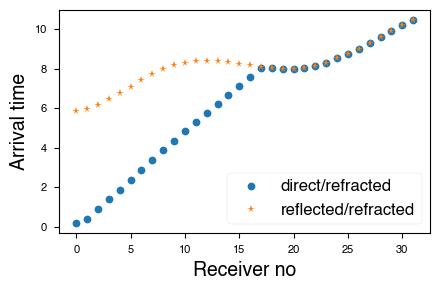

In [10]:
plt.figure(figsize=(4.5,3))

plt.plot(tt[:nRx], 'o', label='direct/refracted')
plt.plot(tt2, '*', label='reflected/refracted')
plt.legend(fontsize=12)

plt.xlabel('Receiver no', fontsize=14)
plt.ylabel('Arrival time', fontsize=14)
plt.tight_layout()
plt.savefig('figs/example2_tt.pdf', bbox_inches='tight')

plt.show()